### ANFIS for Dataset 2 (Classification)

In [3116]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


In [3117]:
# CHOOSE DATASET

# 1. Regression
# diabetes = datasets.load_diabetes(as_frame=True)
# X = diabetes.data.values
# y = diabetes.target.values

# 2. Classification
diabetes = datasets.fetch_openml(name="diabetes", version=1, as_frame=True)
X = diabetes.data.values
y = diabetes.target.astype(str).map({'tested_positive': 1, 'tested_negative': 0}).values

In [3118]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [3119]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


### Clustering Hyperparameters
- **`n_clusters`** – Number of fuzzy clusters. Controls model complexity.  
- **`m`** – Fuzziness coefficient in fuzzy c-means. Higher `m` makes clusters fuzzier (wider membership finctions). `m=1` corresponds to hard clustering.  

After tuning the model, the following values were chosen for the different datasets.  
**Regression**: `n_clusters`=2, `m`=2  
**Classification**: `n_clusters`=2, `m`=3

In [3120]:
 # Number of clusters 
n_clusters = 2
m = 3

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [3121]:
centers.shape

(2, 9)

In [3122]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.5000002846707329


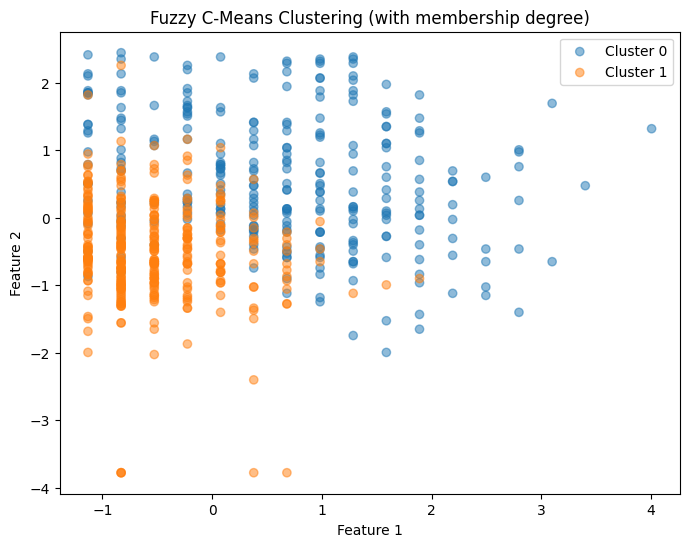

In [3123]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

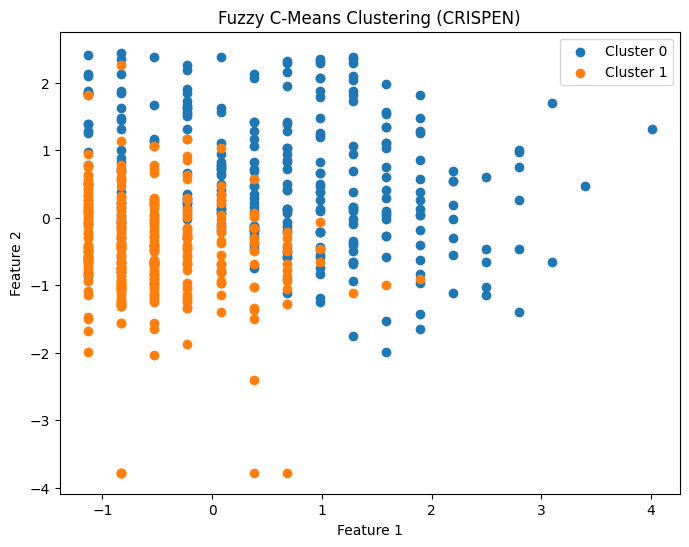

In [3124]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

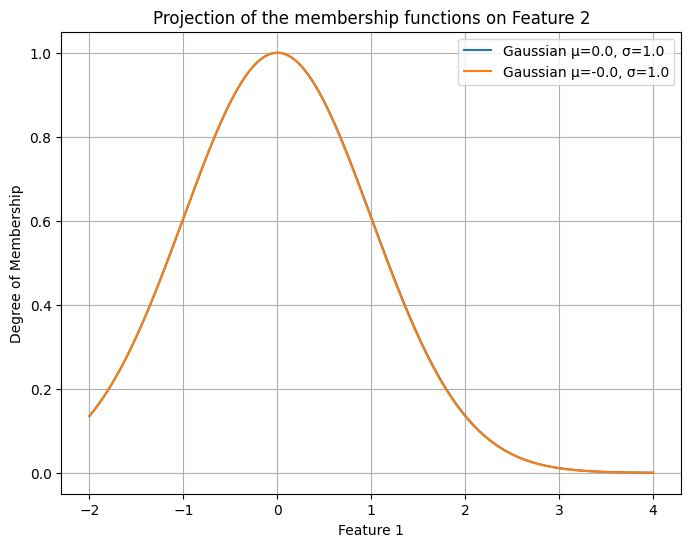

In [3125]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [3126]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [3127]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [3128]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [3129]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [3130]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [3131]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


<!-- **Parameters**  
`max_iters`: how many times run for loop  
`gd_epochs`: how many epochs for gd  
`lr`: learning rate. How big adjustments? Bigger lr -> quicker convergance. Can't be too big since it might converge to an incorrect solution   -->

### Hyperparameters
- **`max_iters`** – Number of hybrid training cycles, alternating between gradient descent and least squares. (Default value = 10)  
- **`gd_epochs`** – Number of epochs for the gradient descent step in each cycle. (Default value = 20)  
- **`lr`** – Learning rate. Controls the size of parameter updates during gradient descent. (Default value = 0.001)  
  - Higher `lr` → faster convergence but risk of instability or finding incorrect local minima.  
  - Lower `lr` → more stable but slower training.  

After tuning the model, the following values were chosen for the different datasets:  
**Regression**: `max_iters`=7, `gd_epochs`=10, `lr`=0.001  
**Classification**: `max_iters`=8, `gd_epochs`=15, `lr`=0.001  
  
Important to note is that these values are not necessarily fully optimized. Training the model over and over with the same hyperparameters can give very different performance.

In [3132]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1), max_iters=8, gd_epochs=15, lr=0.001)


tensor(0.1524, grad_fn=<MseLossBackward0>)
tensor(0.1808, grad_fn=<MseLossBackward0>)
tensor(0.1535, grad_fn=<MseLossBackward0>)
tensor(0.1577, grad_fn=<MseLossBackward0>)
tensor(0.1660, grad_fn=<MseLossBackward0>)
tensor(0.1614, grad_fn=<MseLossBackward0>)
tensor(0.1530, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1550, grad_fn=<MseLossBackward0>)
tensor(0.1585, grad_fn=<MseLossBackward0>)
tensor(0.1564, grad_fn=<MseLossBackward0>)
tensor(0.1517, grad_fn=<MseLossBackward0>)
tensor(0.1497, grad_fn=<MseLossBackward0>)
tensor(0.1516, grad_fn=<MseLossBackward0>)
tensor(0.1542, grad_fn=<MseLossBackward0>)
tensor(0.1497, grad_fn=<MseLossBackward0>)
tensor(0.1751, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1539, grad_fn=<MseLossBackward0>)
tensor(0.1628, grad_fn=<MseLossBackward0>)
tensor(0.1578, grad_fn=<MseLossBackward0>)
tensor(0.1499, grad_fn=<MseLossBackward0>)
tensor(0.1490, grad_fn=<MseLossBackward0>)
tensor(0.15

We print `mean_squared_error` and `accuracy_score` as indications of the performance of the model for regression and classification respectively.

In [3134]:
y_pred, _, _=model(Xte)
# Performance metric for regression
# print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') 

# Performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') 

ACC:0.7857142857142857
